# Assignment 3: Predicting the probability of default of credit card clients

**Deadline**:  Tue 10-Dec 2019, 23:59

|Nr|**Name**|**Student ID**|**Email**|
|--|--------|--------------|---------|
|1.| Shuvani Choudhury|12768553|shuvani511nl@gmail.com|
|2.|        |              |         |
|3.|        |              |         |

**Declaration of Originality**

We whose names are given under 1., 2. and 3. above declare that:
1. These solutions are solely our own work.
2. We have not made (part of) these solutions available to any other student.
3. We shall not engage in any other activities that will dishonestly improve my results or dishonestly improve or hurt the results of others.

## Instructions for completing and submitting the assignment
Please pay attention to the following instructions:
1. Please follow carefully the steps outlined in the assignment. If you cannot solve an exercise and this hinders continuing with subsequent exercises, try to find a way to work around it and give a clear explanation for the solution you have chosen.
2. Submit your work in the form of a Jupyter notebook via Canvas, before the deadline. Your notebook should not give errors when executed with `Run All`.
3. Most of your answers will consist of code. Make sure your code is well structured, efficient and provided with comments where needed. These aspects will be taken into account in the grading of your work.
4. Sometimes you are asked to explain your code or to motivate your choices. Please be concise and use your own words in answering those questions.
5. You are allowed to work on the assignment in groups of 2 or 3 students and to submit together.

## Goal
The goal of this assignment is to predict the probability of default of credit card clients using
- logistic regression
- neural network
- random forest
- AdaBoost

Using the techniques mentioned above, we ask you to come up with a model that has the best generalization performance.


## Test set
There are 30,000 observations, but for only the first 25,000 the target values are given. The other 5,000 target values will be used to assess your performance. The assignment is also a competition:  your mark (20%) depends on how well your model does on the test set compared to those of other groups.

# Initialize and get the data

First, we initialize some libraries, define an overlay histogram & a nice graphical confusion matrix, and read the data.

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def draw_histogram(varname):
    x0=df[varname][df.Y==0]
    x1=df[varname][df.Y==1]
    count0, bin_limits = np.histogram(x0,bins=30)
    count1, _          = np.histogram(x1,bins=bin_limits)
    plt.hist(x0,bins=bin_limits,color='LightBlue')
    plt.hist(x1,bins=bin_limits,color='DarkRed')
    ### normalized overlay histogram
    count_tot=count0+count1
    with np.errstate(divide='ignore',invalid='ignore'):
        count0rel=np.where(count_tot==0,np.nan,count0/(count0+count1))
        count1rel=np.where(count_tot==0,np.nan,count1/(count0+count1))
    labels=np.round((bin_limits[1:]+bin_limits[:-1])/2,1)    # determine middle of classes
    DataFrame({'0':count0rel,'1':count1rel},index=labels)[['1','0']].plot.bar(stacked=True,color=('DarkRed','LightBlue'));

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
df = pd.read_csv('MLE_Assignment3_data2019.csv')
df_labels=['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3',
'BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','default payment next month']
df.columns
df_t=df['Y']                # select target variabel (as pandas series)
df_X=df.loc[:,'X1':'X23']   # select features (as pandas dataframe)

## Rate of default: around 22%

In [2]:
freq=df_t.value_counts()/(len(df_t)-df_t.isnull().sum())
freq.plot(kind='pie',title='Probability of default',figsize=(6, 6)); 
print(freq)

0.0    0.78012
1.0    0.21988
Name: Y, dtype: float64


## Definition of variables

This assignment employs a binary variable, default payment (Yes = 1, No = 0), as the response variable `t` in October 2005 from an important bank in Taiwan. The data consist of the following 23 variables as explanatory variables: 

- `X1`: Amount of the given credit (NT dollar=New Taiwan $): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- `X2`: Gender (1 = male; 2 = female). 
- `X3`: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- `X4`: Marital status (1 = married; 2 = single; 3 = others). 
- `X5`: Age (years). 
- `X6 - X11`: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: `X6` = the repayment status in September, 2005; `X7` = the repayment status in August, 2005; . . .;`X11` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- `X12-X17`: Amount of bill statement (NT dollar). `X12` = amount of bill statement in September, 2005; `X13` = amount of bill statement in August, 2005; . . .; `X17` = amount of bill statement in April, 2005. 
- `X18-X23`: Amount of previous payment (NT dollar). `X18` = amount paid in September, 2005; `X19` = amount paid in August, 2005; . . .;`X23` = amount paid in April, 2005. 

# Creating features

Some variable (at least `X2`-`X4`) have to be dummified. We start with `X1` and add columns to the dataframe.

In [3]:
data=pd.DataFrame(df['X1'],columns=['X1'])
X2_dum=pd.get_dummies(df['X2'], prefix='X2',drop_first=True)
data=pd.merge(data,X2_dum,left_index=True, right_index=True)
X3_dum=pd.get_dummies(df['X3'], prefix='X3',drop_first=True)
data=pd.merge(data,X3_dum,left_index=True, right_index=True)
X4_dum=pd.get_dummies(df['X4'], prefix='X4',drop_first=True)
data=pd.merge(data,X4_dum,left_index=True, right_index=True)

## Should `X6-X17` be dummified?

You can use `draw_histogram()` to create overlay histograms. The first histogram shows the absolute frequencies, where red bars indicate defaults. The second one shows the normalized frequencies. In this way we can judge whether the effect is linear or not. Below, we look at the variable `X6`.

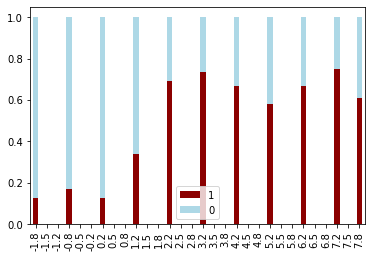

In [4]:
draw_histogram('X6')

## Finalizing the features

Below, we choose to not dummify the variables `X6`-`X17` out of convenience. Whether this is justified is up to you.<BR> Furthermore, non-dummy variables are standardized.<BR>
Some procedures require numpy array/matrix, so this is also defined. `Xlabels[i]` gives the label of `X[:,i]`.

In [5]:
data=pd.merge(data,df.loc[:,'X6':'X23'],left_index=True, right_index=True)
cols = list(data.columns)
for col in cols:   # loop over all columns
    if np.abs(data[col].mean())>1:    # check if dummy
        data[col] = (data[col] - data[col].mean())/data[col].std(ddof=1)   # no dummy: than standardize
t=df_t.values   # convert to numpy array
X=data.values   # convert to numpy matrix
Xlabels=data.columns
data.describe()

X1          X2_2          X3_1          X3_2          X3_3  \
count  3.000000e+04  30000.000000  30000.000000  30000.000000  30000.000000   
mean  -1.905890e-15      0.603733      0.352833      0.467667      0.163900   
std    1.000000e+00      0.489129      0.477859      0.498962      0.370191   
min   -1.213774e+00      0.000000      0.000000      0.000000      0.000000   
25%   -9.054832e-01      0.000000      0.000000      0.000000      0.000000   
50%   -2.118290e-01      1.000000      0.000000      0.000000      0.000000   
75%    5.588978e-01      1.000000      1.000000      1.000000      0.000000   
max    6.416421e+00      1.000000      1.000000      1.000000      1.000000   

               X3_4          X3_5          X3_6          X4_1          X4_2  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean       0.004100      0.009333      0.001700      0.455300      0.532133   
std        0.063901      0.096159      0.041197      0.498006      0.498975   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      1.000000   
75%        0.000000      0.000000      0.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       ...           X14           X15           X16           X17  \
count  ...  3.000000e+04  3.000000e+04  3.000000e+04  3.000000e+04   
mean   ... -1.715295e-17  1.658303e-17  6.371570e-17 -3.479069e-17   
std    ...  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min    ... -2.945623e+00 -3.314993e+00 -2.000840e+00 -6.355141e+00   
25%    ... -6.394708e-01 -6.363187e-01 -6.340494e-01 -6.316233e-01   
50%    ... -3.882465e-01 -3.763388e-01 -3.652622e-01 -3.660664e-01   
75%    ...  1.896426e-01  1.747637e-01  1.624928e-01  1.733968e-01   
max    ...  2.331781e+01  1.318647e+01  1.458719e+01  1.549502e+01   

                X18           X19           X20           X21           X22  \
count  3.000000e+04  3.000000e+04  3.000000e+04  3.000000e+04  3.000000e+04   
mean  -4.753753e-16  2.400626e-16  5.278648e-17  1.159776e-16  2.276105e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -3.419359e-01 -2.569852e-01 -2.967963e-01 -3.080574e-01 -3.141309e-01   
25%   -2.815614e-01 -2.208321e-01 -2.746460e-01 -2.891632e-01 -2.976042e-01   
50%   -2.151494e-01 -1.697923e-01 -1.945640e-01 -2.123096e-01 -2.159525e-01   
75%   -3.970110e-02 -3.997954e-02 -4.093162e-02 -5.188424e-02 -5.026000e-02   
max    5.239834e+01  7.284177e+01  5.059444e+01  3.933152e+01  2.760317e+01   

                X23  
count  3.000000e+04  
mean  -9.278837e-16  
std    1.000000e+00  
min   -2.933772e-01  
25%   -2.867536e-01  
50%   -2.090007e-01  
75%   -6.837322e-02  
max    2.944461e+01  

[8 rows x 29 columns]

## Training and validation set
Note that the test set (last 5,000 observations) cannot be used to assess the predictive accuracy of your model. <BR>
Hence, we split out sample (first 25,000 observations) into a training and validation set.<BR>
You could also use cross-validation (on the first 25K obs.), but for now we keep it simple.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, t_train, t_val = train_test_split(X[:25000], t[:25000], random_state=1, test_size=0.25)

# Logistic regression

Let's start with a basic logistic regression as our baseline.

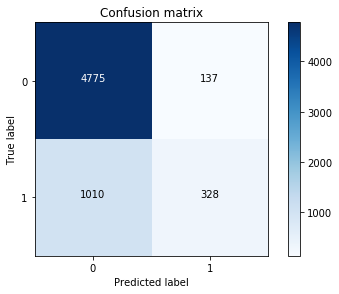

Accuracy: 0.816


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

clf = LogisticRegression(random_state=1, solver='lbfgs',C=1E9,max_iter=1000)    # almost no regularization
clf.fit(X_train, t_train)     # fit the model
t_pred=clf.predict(X_val)     # predict taget variable for the validation set
cnf_matrix = confusion_matrix(t_val, t_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');plt.show()
acc=accuracy_score(t_val, t_pred)   
print(f'Accuracy: {acc:.3f}')

# Basic Neural Network (one-hidden-layer neural network )

- Note: you can just use `Keras` to train your Network.
- Did you check convergence?

Epoch 1/150
18750/18750 [==============================] - 2s 124us/step - loss: 0.4653 - acc: 0.8110
Epoch 2/150
18750/18750 [==============================] - 2s 106us/step - loss: 0.4463 - acc: 0.8173
Epoch 3/150
18750/18750 [==============================] - 2s 107us/step - loss: 0.4425 - acc: 0.8182
Epoch 4/150
18750/18750 [==============================] - 2s 102us/step - loss: 0.4381 - acc: 0.8194
Epoch 5/150
18750/18750 [==============================] - 2s 98us/step - loss: 0.4359 - acc: 0.8193
Epoch 6/150
18750/18750 [==============================] - 2s 104us/step - loss: 0.4342 - acc: 0.8192
Epoch 7/150
18750/18750 [==============================] - 2s 113us/step - loss: 0.4321 - acc: 0.8205
Epoch 8/150
18750/18750 [==============================] - 2s 97us/step - loss: 0.4317 - acc: 0.8211
Epoch 9/150
18750/18750 [==============================] - 2s 97us/step - loss: 0.4312 - acc: 0.8215
Epoch 10/150
18750/18750 [==============================] - 2s 100us/step - loss: 0.4

18750/18750 [==============================] - 3s 145us/step - loss: 0.4181 - acc: 0.8223
Epoch 77/150
18750/18750 [==============================] - 3s 157us/step - loss: 0.4172 - acc: 0.8235
Epoch 78/150
18750/18750 [==============================] - 3s 147us/step - loss: 0.4176 - acc: 0.8237
Epoch 79/150
18750/18750 [==============================] - 3s 139us/step - loss: 0.4172 - acc: 0.8227
Epoch 80/150
18750/18750 [==============================] - 2s 111us/step - loss: 0.4174 - acc: 0.8235
Epoch 81/150
18750/18750 [==============================] - 2s 131us/step - loss: 0.4180 - acc: 0.8222
Epoch 82/150
18750/18750 [==============================] - 2s 102us/step - loss: 0.4175 - acc: 0.8228
Epoch 83/150
18750/18750 [==============================] - 3s 141us/step - loss: 0.4169 - acc: 0.8232
Epoch 84/150
18750/18750 [==============================] - 2s 112us/step - loss: 0.4167 - acc: 0.8252 2s - loss: 0.4778 -  - ETA: 1
Epoch 85/150
18750/18750 [==============================

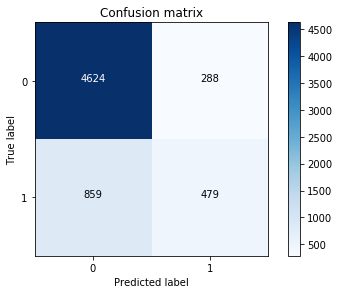

Accuracy: 0.816


In [47]:
from keras.models import Sequential
from keras.layers import Dense

# Define the neural network
model = Sequential()
model.add(Dense(25, input_dim=29, activation='relu'))
model.add(Dense(1, activation="sigmoid"))

# Compile the neural network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the neural network (on the training set)
model.fit(X_train, t_train, epochs=150, batch_size=10)

#Get predictions and classify predictions according to a basic threshold (0.5)
t_pred=model.predict(X_val) 
t_pred = (t_pred > 0.5)

#Get the resulting confusion matrix
cnf_matrix = confusion_matrix(t_val, t_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');plt.show()
acc=accuracy_score(t_val, t_pred)  
print(f'Accuracy: {acc:.3f}')

# Basic Random forest

- Also try to use undummified data, so let the decision tree decide on the splitting.

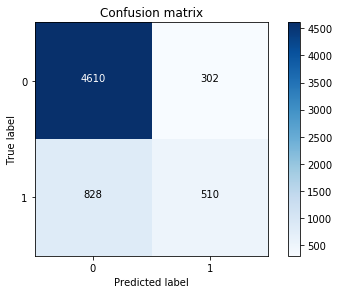

Accuracy: 0.819


In [43]:
from sklearn.ensemble import RandomForestClassifier

#Define the random forest algorithm
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")

#Fit the random forest (on the training set)
rf_clf.fit(X_train, t_train)

#Get predictions and classify predictions according to a basic threshold (0.5)
t_pred=rf_clf.predict(X_val) 
t_pred = (t_pred > 0.5)

#Get the resulting confusion matrix
cnf_matrix = confusion_matrix(t_val, t_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');plt.show()
acc=accuracy_score(t_val, t_pred)   
print(f'Accuracy: {acc:.3f}')

# Basic AdaBoost

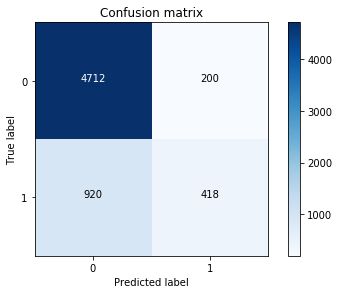

Accuracy: 0.821


In [45]:
from sklearn.ensemble import AdaBoostClassifier

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
abc_cf = abc.fit(X_train, t_train)

#Get predictions and classify predictions according to a basic threshold (0.5)
t_pred=abc_cf.predict(X_val) 
t_pred = (t_pred > 0.5)

#Get the resulting confusion matrix
cnf_matrix = confusion_matrix(t_val, t_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');plt.show()
acc=accuracy_score(t_val, t_pred)   
print(f'Accuracy: {acc:.3f}')

# Advanced Classifier

**Choose one** of the above basic classifiers (which seems most promising to you) and optimize as much as possible. You can think of:
- optimize hyper parameters/regularization using CV validation
- optimize your dummification/binning with respect to the target variable
- including interactions between (transformed) features.

Please  make  sure  all  steps  are  well  motivated  and  presented  in  a  clear and structured way.

In [ ]:
#Chose to perfect the random forest algorithm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

#Tune the hyperparameters of the forest to optimize the algorithm
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#Fit the random forest model based on random grid parameteres
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, t_train)

#Find the best parameters
rf_random.best_params_

#Evaluate the best random forest
best_random = rf_random.best_estimator_
t_pred = best_random.predict(X_val)
t_pred = (t_pred > 0.5)

#Get the resulting confusion matrix
cnf_matrix = confusion_matrix(t_val, t_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');plt.show()
acc=accuracy_score(t_val, t_pred)   
print(f'Accuracy: {acc:.3f}')

Based on the results of the cross-validated search grid, the following parameters were deemed optimal:
n_estimators- 1600,
min_samples_split- 2,
min_samples_leaf- 4,
max_features- sqrt,
max_depth- 10,
bootstrap- True.

Hence, the resulting accuracy was seen to have increased by 0.6%.

0.7872685574025116
          fpr       tpr     1-fpr       tf  thresholds
936  0.285831  0.714499  0.714169  0.00033    0.179522


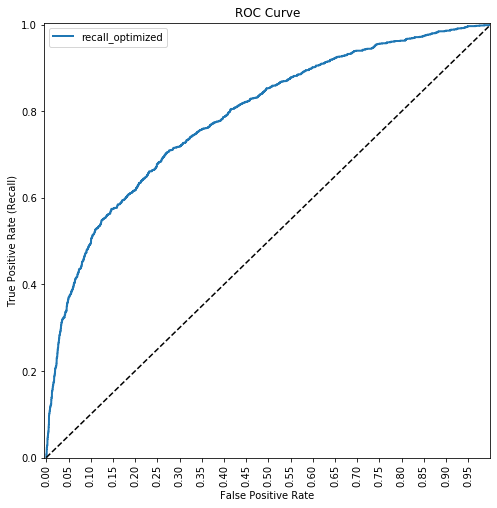

In [89]:
#Choose the optimal threshold for the classifier
from sklearn.metrics import roc_curve, auc
import pylab as pl

#Calculate the true positive and false positive rates
t_pred = best_random.predict(X_val)
fpr, tpr, thresholds = roc_curve(t_val, t_pred)
roc_auc = auc(fpr,tpr)
print(roc_auc) # AUC of ROC

#Plot the ROC Curve
plt.figure(figsize=(8,8))
plt.title('ROC Curve')
plt.plot(fpr, tpr, linewidth=2, label='recall_optimized')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0,1, 0.05), rotation=90)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc='best')

#Get the optimal threshold for the classifier
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]

print(roc_t)

#Test the new threshold
t_pred = (t_pred > 0.179522)

#Get the resulting confusion matrix
cnf_matrix = confusion_matrix(t_val, t_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');plt.show()
acc=accuracy_score(t_val, t_pred)   
print(f'Accuracy: {acc:.3f}')

While in theory, an ROC curve should reveal the optimal threshold as one with a high true positive rate and a low false positive rate, unfortunately, the threshold revealed in this instance did not perform as well as expected.

Therefore, the threshold was kept at its default value instead, 0.5.

# Finally, generate your predictions for the test set and save them into your notebook

Generate predictions for the last 5,000 observations (of the csv-file):
- use the correct X-values! For instance, if you don't change the numpy matrix `X`, you can use `X[-5000:]` to make the predictions
- think what properties your predictions should have (continuous or discrete)
- of course, you can't determine the accuracy
- if you have performed some transformations, please be sure to apply them also on the last 5K obs (as is done in the example above)
- save your predictions in the variable `t_pred` and save them into your notebook using `%store t_pred`

In [90]:
t_pred=best_random.predict(X[-5000:])
%store t_pred

Stored 't_pred' (ndarray)
